### Ra ngoài cài thư viện trước

#### pip install pymongo
#### pip install numpy
#### pip install pandas
#### pip install scikit-learn
#### pip install matplotlib
#### conda install tensorflow==2.2
#### conda install keras

(array([ 17.,  50.,  97., 119., 161., 112.,  68.,  37.,   8.,   4.]),
 array([160., 217., 274., 331., 388., 445., 502., 559., 616., 673., 730.]),
 <BarContainer object of 10 artists>)

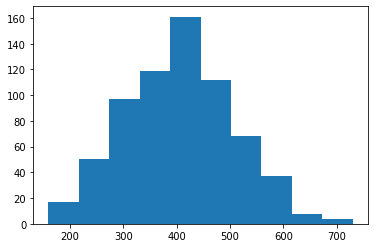

In [10]:
import json
import numpy as np
from bson import ObjectId
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

with open("default.json", "r", encoding="utf-8") as json_file:
    default_data = json.load(json_file)

COUNT_OK = 630
COUNT_ERROR = 43

lst = [*[1 for i in range(COUNT_OK)], *[0 for i in range(COUNT_ERROR)]]
np.random.shuffle(lst)

properties = default_data["properties"]
properties_len = len(properties)
rooms_default = default_data["rooms"]
rooms_default_len = len(rooms_default)
rooms = []
rooms2 = []

map_facility = ["1 Giường đơn", "1 Giường đôi"]
map_bed = {0: 30, 1: 40}
map_city = {"1": 30, "2": 50, "3": 25, "4": 20, "5": 10}
map_property_type = {"1": 30, "2": 70, "3": 60, "4": 35, "5": 15, "6": 45, "7": 55, "8": 50, "9": 60}
map_meal = {0: 25, 1: 35, 2: 45, 3: 55, 4: 65}

for i in range(COUNT_OK + COUNT_ERROR):
    room = (rooms_default[np.random.randint(0, rooms_default_len)]).copy()
    room["_id"] = str(ObjectId())
    acreage = room["acreage"] = 12 + np.random.randint(0, 20)
    bed_type = room["bed_type"] = np.random.randint(0, 2)
    room["facility"] = map_facility[bed_type]
    property_id = room["property_id"] = str(np.random.randint(1, properties_len + 1))
    p1 = None
    for p in properties:
        if p["_id"] == property_id:
            p1 = p
            break
    room2 = room.copy()
    room2["distance"] = distance = p1["distance_from_center"]
    if distance < 400:
        distance = 400
    elif distance > 4000:
        distance = 4000
    room2["near_beach"] = near_beach = p1["is_near_beach"]
    room2["rank"] = rank = p1["rank"]
    room2["meal"] = meal = p1["meal"]
    room2["city"] = city = p1["city_id"]
    room2["property_type"] = property_type = p1["property_type_id"]

    price = acreage * 8 + map_bed[bed_type] + 20000 / distance + near_beach * 50 + (rank - 2.5) * 60 + map_meal[meal] + \
            map_city[city] + map_property_type[property_type]
    if lst[i] == 1:
        price += np.random.randint(-50, 50)
    else:
        price += np.random.randint(-100, 100)
    price = int(price / 10) * 10
    room2["price"] = room["price"] = price
    rooms.append(room)
    rooms2.append(room2)

with open("generate.json", "w", encoding="utf-8") as json_file:
    json.dump(rooms, json_file, indent=4, ensure_ascii=False)

df = pd.DataFrame(rooms2)
plt.hist(df["price"])

In [11]:
data = df[["acreage", "bed_type", "distance", "near_beach", "rank", "meal", "city", "property_type", "price"]]
data.head()

,acreage,bed_type,distance,near_beach,rank,meal,city,property_type,price
0,14,1,150,0,3.9,4,2,7,420
1,12,0,6436,0,2.8,1,2,3,330
2,27,1,3005,1,1.1,3,3,5,320
3,31,1,1045,0,3.0,2,1,1,390
4,24,0,1410,0,4.7,1,1,3,530


In [12]:
for i in range(len(data)):
    data.at[i, "city"] = float(data["city"][i])
    data.at[i, "property_type"] = float(data["property_type"][i])
x = data[["acreage", "bed_type", "distance", "near_beach", "rank", "meal", "city", "property_type"]]
y = data["price"]

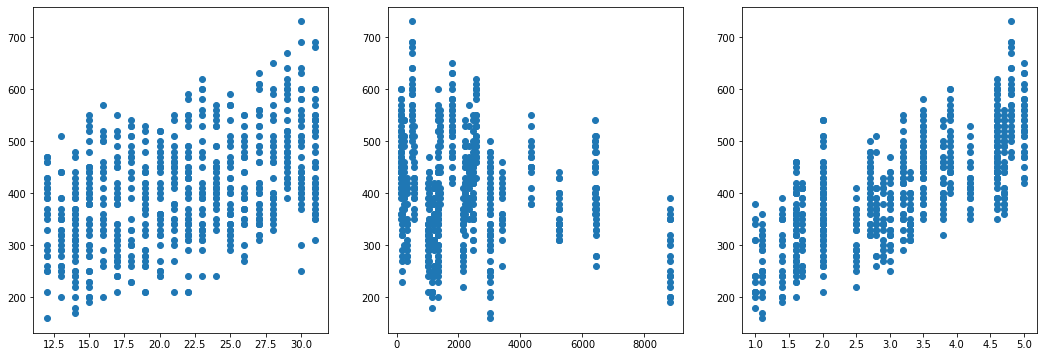

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.scatter(data["acreage"], data["price"])
ax2.scatter(data["distance"], data["price"])
ax3.scatter(data["rank"], data["price"])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x).astype(float), np.array(y).astype(float), test_size=0.2, random_state=42)

### Linear Regression

Score:  0.9026328927549938
Predict:  302.4610448097314
Real:  280.0


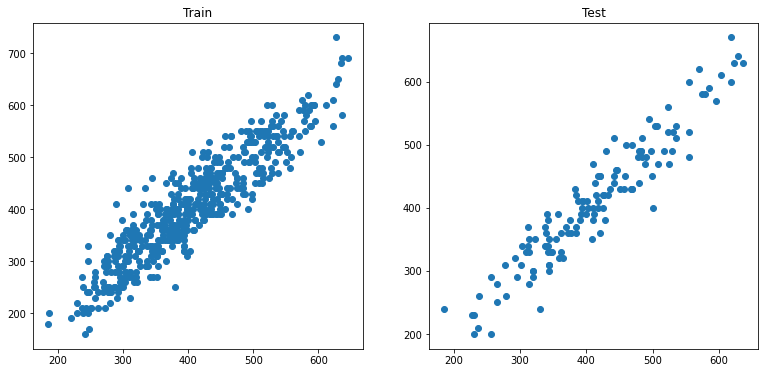

In [17]:
linear = LinearRegression()
linear.fit(x_train, y_train)
print("Score: ", linear.score(x_test, y_test))

print("Predict: ", linear.predict([x_train[0]])[0])
print("Real: ", y_train[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.scatter(linear.predict(x_train), y_train)
ax1.title.set_text("Train")
ax2.scatter(linear.predict(x_test), y_test)
ax2.title.set_text("Test")

### Neural network

In [ ]:
import keras

from keras.layers import Dense
from keras.models import Sequential

learning_rate = 0.1

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(8, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate))

model.fit(x_train, y_train, batch_size=128, epochs=100)

In [ ]:
print("Predict: ", model.predict(np.array([x_train[0]]))[0][0])
print("Real: ", y_train[0])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.scatter(model.predict(x_train), y_train)
ax1.title.set_text("Train")
ax2.scatter(model.predict(x_test), y_test)
ax2.title.set_text("Test")

### Save model

In [ ]:
model.save('model.h5')

### Load model

In [ ]:
from keras.models import load_model

model = load_model('model.h5')